# Mixed-state ptychography figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the mixed-state ptychography figure (Fig. 11) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from emdfile import tqdmnd
from abtem.noise import poisson_noise

## abTEM Simulations

In [2]:
class doughnut_CTF(abtem.CTF):
    
    def __init__(
        self,
        complementary: bool = False,
        semiangle_cutoff: float = np.inf, 
        energy: float = None, 
        parameters = None
    ):
        """ Doughnut-shape probe """
        self._complementary = complementary
        super().__init__(semiangle_cutoff=semiangle_cutoff, rolloff=0., energy=energy, parameters=parameters)
        
    def evaluate(self, alpha, phi):
        """ Overwrite aperture """
        array  = self.evaluate_aberrations(alpha, phi) 
        array *= self.evaluate_aperture(alpha,phi)
        
        xp     = abtem.device.get_array_module(array)
        alpha  = xp.array(alpha)*1000.
        
        if self._complementary:
            array *= xp.sin(2*np.pi*alpha/self.semiangle_cutoff) >= 0.
        else:
            array *= xp.sin(2*np.pi*alpha/self.semiangle_cutoff) < 0.
                
        return array

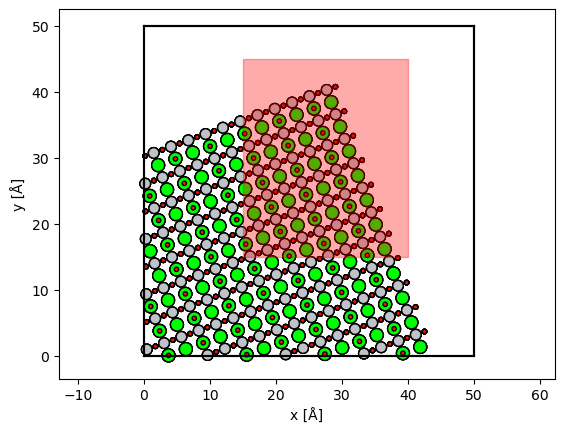

In [3]:
STO_unit_cell = ase.io.read("data/SrTiO3.cif")
STO_atoms = ase.build.surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)
STO_atoms_thick = STO_atoms * (5,5,2)
STO_atoms_thick.rotate(20, 'z')
STO_atoms_thick.translate((15,25,0))
STO_atoms_thick.center(axis=(0,1))
STO_atoms_thick.translate((-15,-25,0))
del STO_atoms_thick[STO_atoms_thick.positions[:,0]<0]
del STO_atoms_thick[STO_atoms_thick.positions[:,1]<0]

STO_atoms_thick.cell[0,0]=50
STO_atoms_thick.cell[1,1]=50

gridscan = abtem.GridScan(
    (15, 15), 
    (40, 45), 
    sampling=0.5,
    endpoint=True
)

abtem.show_atoms(STO_atoms_thick,scans=gridscan);

In [4]:
frozen_phonons = abtem.temperature.FrozenPhonons(STO_atoms_thick, 12, 0.1)

potential_thick = abtem.Potential(
    #frozen_phonons, # uncomment this for a realistic simulation
    STO_atoms_thick, # comment this for a realistic simulation
    sampling=0.1,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

doughnut_ctf = doughnut_CTF(
    semiangle_cutoff=20,
    energy=200e3,
    parameters={'C10': -100}
)

doughnut_hole_ctf = doughnut_CTF(
    True,
    semiangle_cutoff=20,
    energy=200e3,
    parameters={'C10': -100}
)

doughnut_probe = abtem.Probe(energy=200e3,ctf=doughnut_ctf,device="gpu")
doughnut_probe.match_grid(potential_thick)
doughnut_hole_probe = abtem.Probe(energy=200e3,ctf=doughnut_hole_ctf,device="gpu")
doughnut_hole_probe.match_grid(potential_thick)

pixelated_detector = abtem.PixelatedDetector(max_angle=None)

measurement_doughnut_probe = doughnut_probe.scan(gridscan, pixelated_detector, potential_thick,pbar=True)
sx,sy,qx,qy = measurement_doughnut_probe.shape
qx = (qx-260)//4
qy = (qy-260)//4

incoherent_array = np.zeros((sx,sy,qx,qy))
for ix, iy in tqdmnd(sx,sy, disable=True):
    incoherent_array[ix,iy] = 0.25*measurement_doughnut_probe.array[ix,iy,130:-130,130:-130].reshape((qx,4,qy,4)).sum((1,3))

del measurement_doughnut_probe

measurement_doughnut_hole_probe = doughnut_hole_probe.scan(gridscan, pixelated_detector, potential_thick,pbar=True)
for ix, iy in tqdmnd(sx,sy, disable=True):
    incoherent_array[ix,iy] += 0.75*measurement_doughnut_hole_probe.array[ix,iy,130:-130,130:-130].reshape((qx,4,qy,4)).sum((1,3))

electrons_per_area = 1e4
electrons_per_probe = electrons_per_area*np.array(gridscan.sampling).prod()
noisy_array = np.random.poisson(incoherent_array*electrons_per_probe).astype(np.uint16)

angular_sampling = measurement_doughnut_hole_probe.calibrations[-1].sampling*4
gridscan_sampling = gridscan.sampling[0]

Potential:   0%|          | 0/45 [00:00<?, ?it/s]

Scan:   0%|          | 0/3111 [00:00<?, ?it/s]

Potential:   0%|          | 0/45 [00:00<?, ?it/s]

Scan:   0%|          | 0/3111 [00:00<?, ?it/s]

In [5]:
dc = py4DSTEM.DataCube(data = noisy_array)
dc.calibration.set_R_pixel_size(gridscan_sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(angular_sampling)
dc.calibration.set_Q_pixel_units('mrad')

# py4DSTEM.save("mix-figure_STO-2x4-layers.h5",dc,mode='o')
dc.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    2.006347225386277
             R_pixel_size:    0.5
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

### Single-Slice

In [6]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc,
    verbose=False,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    step_size=0.125,
    max_batch_size = 183,
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [00:12<00:00, 10.23 iter/s]


## Mixed-State

In [7]:
ptycho_mix = py4DSTEM.process.phase.MixedstatePtychography(
    datacube=dc,
    verbose=False,
    energy=200e3,
    num_probes=2,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    step_size=0.125,
    max_batch_size=17,
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [02:59<00:00,  1.40s/ iter]


## Visualization

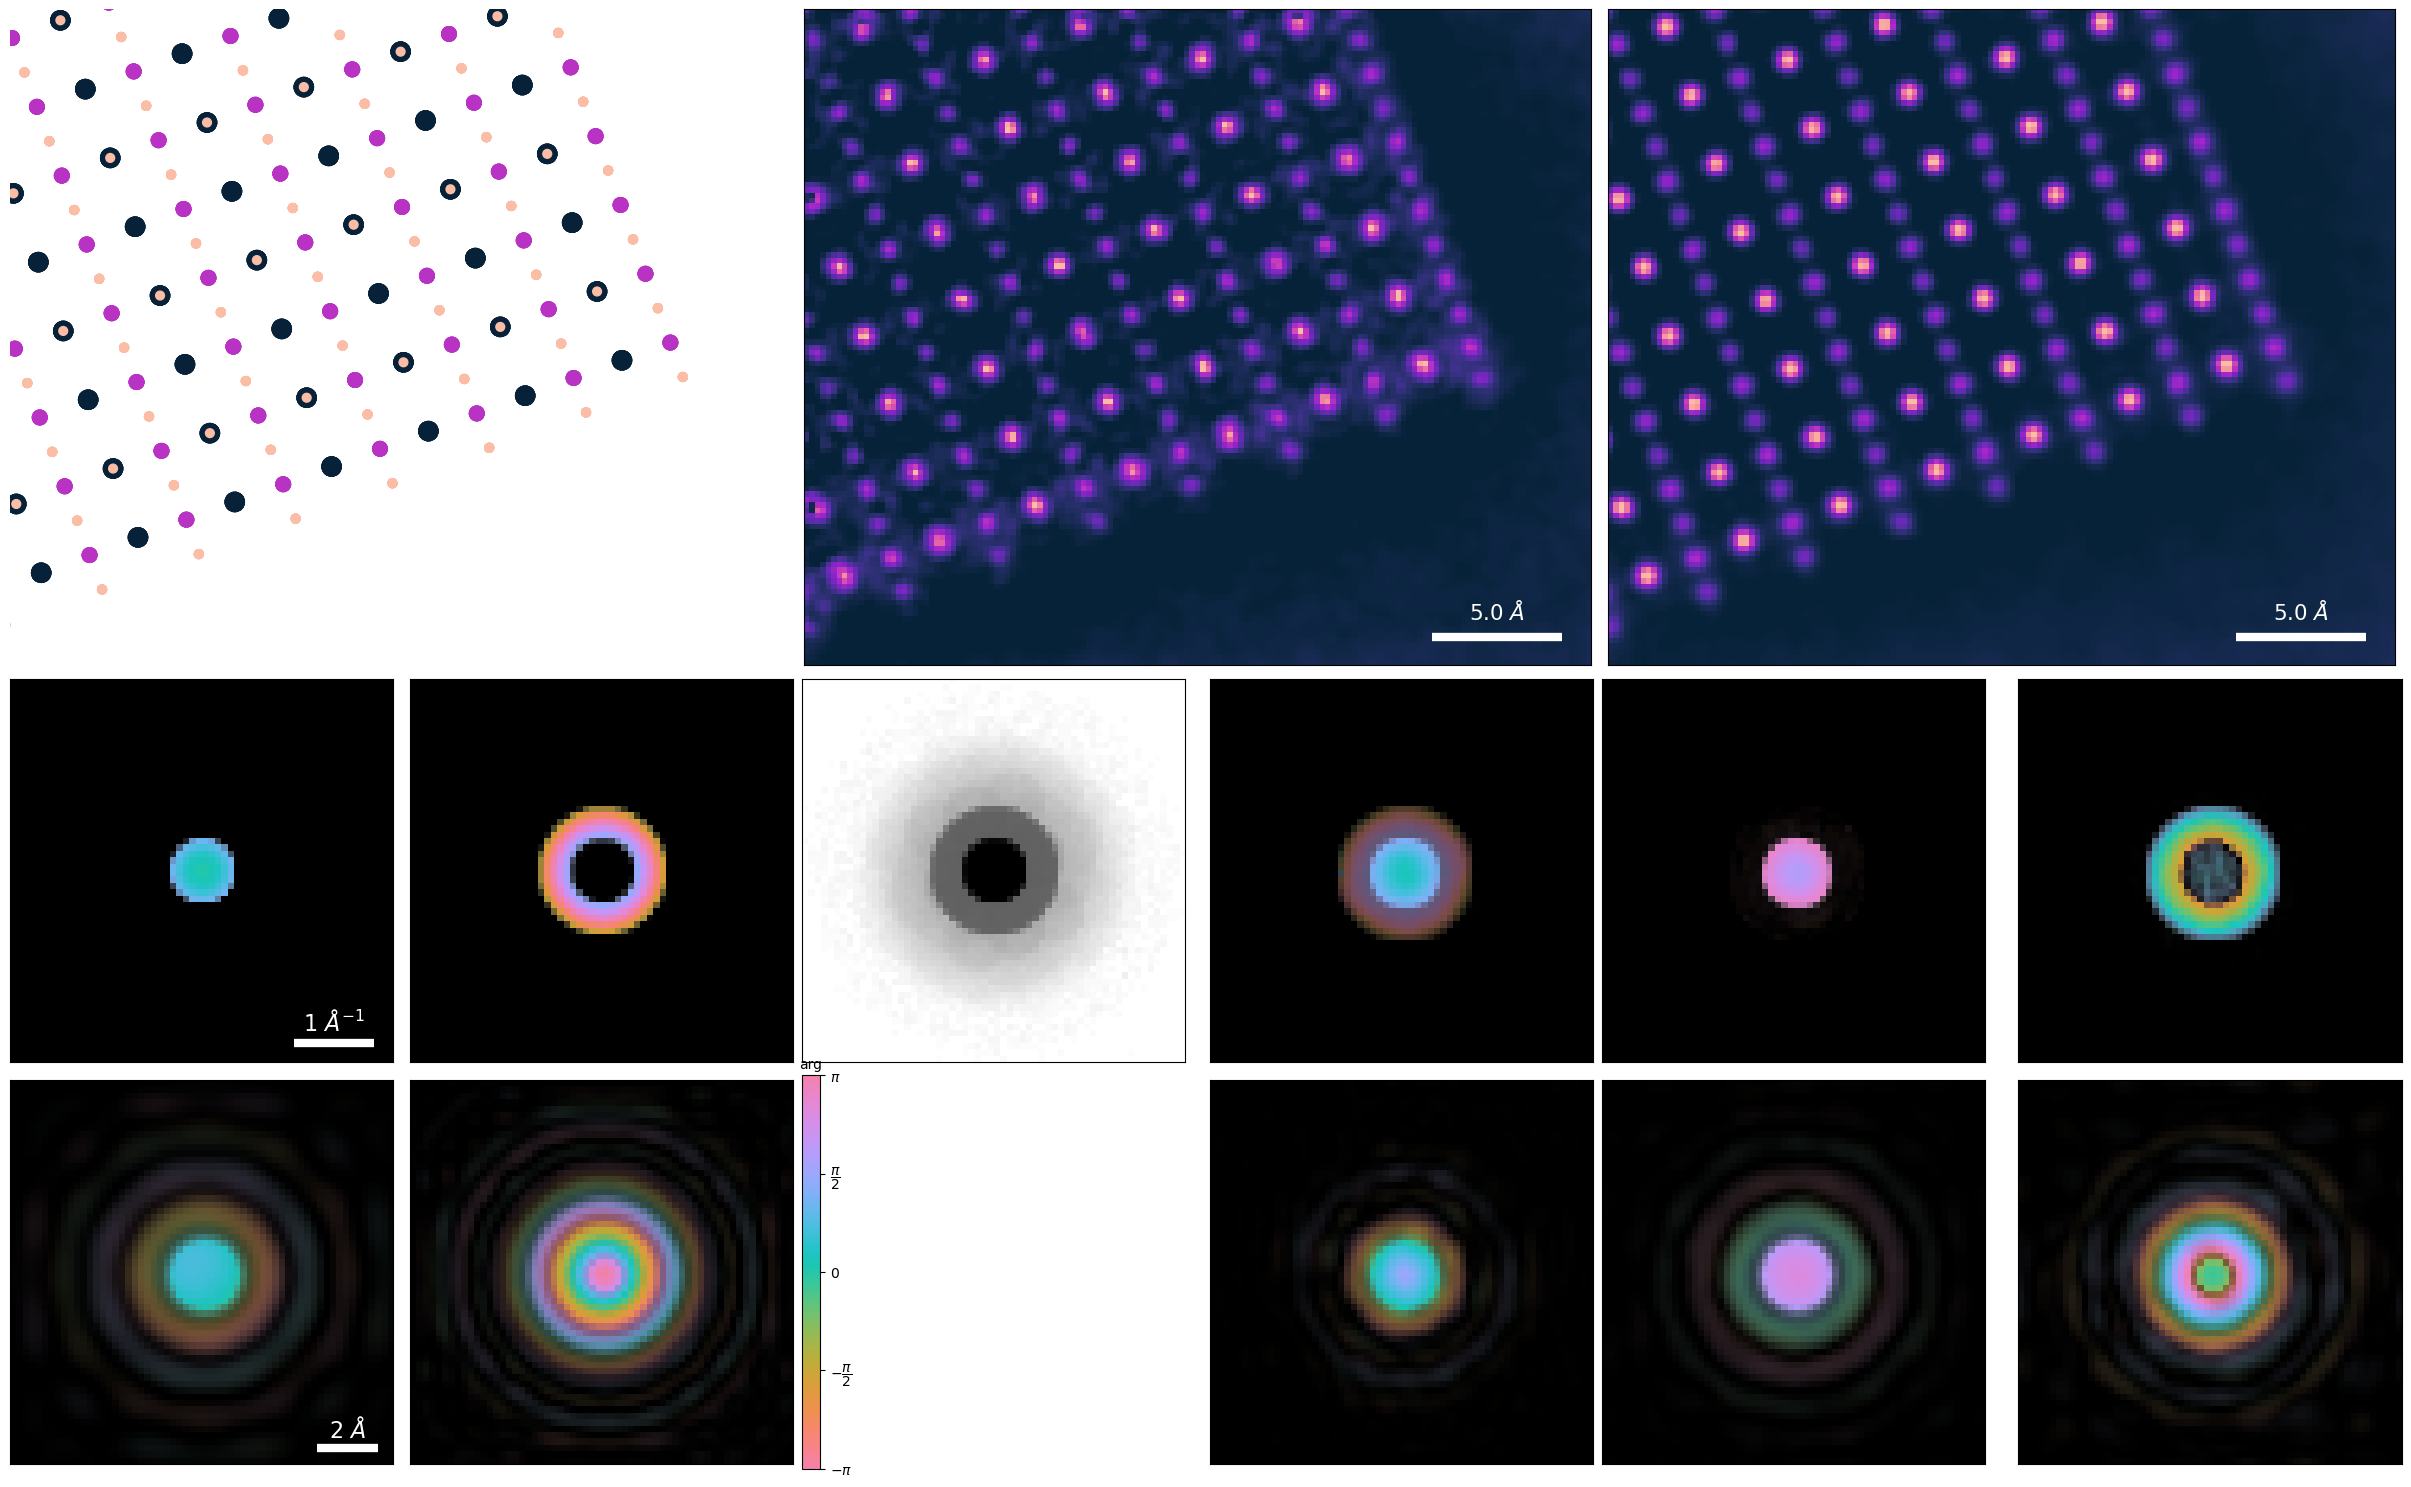

In [8]:
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# spec
fig = plt.figure(constrained_layout=True,figsize=(6*4,(2+121*2/145)*4))
gs = fig.add_gridspec(
    ncols=6,
    nrows=3,
    height_ratios=[121*2/145,1,1],
    wspace=0,
    hspace=0,
)

# axes
ax_model = fig.add_subplot(gs[0, :2])
ax_ss = fig.add_subplot(gs[0, 2:4])
ax_ms = fig.add_subplot(gs[0, 4:6])

ax_hole = fig.add_subplot(gs[1,0])
ax_doughnut = fig.add_subplot(gs[1,1])
ax_hole_rs = fig.add_subplot(gs[2,0])
ax_doughnut_rs = fig.add_subplot(gs[2,1])

ax_dp = fig.add_subplot(gs[1,2])
ax_ss_probe = fig.add_subplot(gs[1,3])
ax_cbar = fig.add_subplot(gs[2,2])
ax_ss_probe_rs = fig.add_subplot(gs[2,3])

ax_ms_hole = fig.add_subplot(gs[1,4])
ax_ms_doughnut = fig.add_subplot(gs[1,5])
ax_ms_hole_rs = fig.add_subplot(gs[2,4])
ax_ms_doughnut_rs = fig.add_subplot(gs[2,5])

# top-row

# atomic-model
scale = 5

ax_model.scatter(
    STO_atoms_thick.positions[:,1], 
    STO_atoms_thick.positions[:,0], 
    c =  STO_atoms_thick.numbers,
    cmap = cmr.bubblegum_r,
    s = STO_atoms_thick.numbers * scale
)

ax_model.set_aspect = "equal"
ax_model.set_xlim([15, 45])
ax_model.set_ylim([40, 15])
ax_model.axis('off')

py4DSTEM.show(
    ptycho._crop_rotate_object_fov(
        np.angle(ptycho.object)
    ),
    vmin=0.333,
    vmax=0.999,
    cmap=cmr.bubblegum,
    ticks=False,
    scalebar=True, 
    pixelsize=ptycho.sampling[0], 
    pixelunits='$\AA$',
    figax=(fig,ax_ss)
)

py4DSTEM.show(
    ptycho._crop_rotate_object_fov(
        np.angle(ptycho_mix.object)
    ),
    vmin=0.333,
    vmax=0.999,
    cmap=cmr.bubblegum,
    ticks=False,
    scalebar=True, 
    pixelsize=ptycho.sampling[0], 
    pixelunits='$\AA$',
    figax=(fig,ax_ms)
)

# simulated probes
alpha, phi = doughnut_probe.get_scattering_angles()
qx,qy = alpha.shape
qx = (qx-260)//4
qy = (qy-260)//4

complex_doughnut = np.fft.fftshift(doughnut_probe.ctf.evaluate(alpha,phi).get())
complex_doughnut = complex_doughnut[130:-130,130:-130].reshape((qx,4,qy,4)).sum((1,3))

complex_hole = np.fft.fftshift(doughnut_hole_probe.ctf.evaluate(alpha,phi).get())
complex_hole = complex_hole[130:-130,130:-130].reshape((qx,4,qy,4)).sum((1,3))

complex_doughnut_rs = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(complex_doughnut)))
complex_hole_rs = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(complex_hole)))

for arr, ax in zip([complex_hole,complex_doughnut,complex_hole_rs,complex_doughnut_rs],[ax_hole,ax_doughnut,ax_hole_rs,ax_doughnut_rs]):
    
    scalebar = ax is ax_hole or ax is ax_hole_rs
    if ax is ax_hole:
        pixelsize = ptycho._reciprocal_sampling[0]
        pixelunits = '$\AA^{-1}$'
    else:
        pixelsize = ptycho.sampling[0]
        pixelunits = '$\AA$'
        
    py4DSTEM.show_complex(
        arr,
        ticks=False,
        cbar=False,
        scalebar=scalebar , 
        pixelsize=pixelsize, 
        pixelunits=pixelunits,
        figax=(fig,ax)
    )

# DP
py4DSTEM.show(
    noisy_array.mean((0,1)),
    vmin=0.333,
    vmax=0.999,
    power=0.25,
    cmap=cmr.neutral_r,
    ticks=False,
    figax =(fig,ax_dp)
)

# colobar
divider = make_axes_locatable(ax_cbar)
ax_cbar_small = divider.append_axes("left",size="5%",pad=0)
ax_cbar.axis("off")
py4DSTEM.visualize.add_colorbar_arg(ax_cbar_small)

# SS
for arr, ax in zip([ptycho.probe_fourier,ptycho.probe_centered],[ax_ss_probe,ax_ss_probe_rs]):

    py4DSTEM.show_complex(
        arr,
        ticks=False,
        cbar=False,
        figax=(fig,ax)
    )

# MS
for arr, ax in zip(np.vstack([ptycho_mix.probe_fourier,ptycho_mix.probe_centered]),[ax_ms_hole,ax_ms_doughnut,ax_ms_hole_rs,ax_ms_doughnut_rs]):

    py4DSTEM.show_complex(
        arr,
        ticks=False,
        cbar=False,
        figax=(fig,ax)
    )

## Postprocessing
> Done in Inkscape